In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib ipympl

In [15]:
import numpy as np
from scipy.spatial.transform import Rotation

In [16]:
import pytransform3d.rotations as pyrot
import pytransform3d.transformations as pytr

In [46]:
import yaml

with open('tf_setup.yaml', 'r') as file:
    tf_statics = yaml.safe_load(file)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager


tm = TransformManager()
for tf in tf_statics['setup']:
    transform = pt.transform_from_pq(
                    np.hstack((
                        np.array([tf['translation']['x'], tf['translation']['y'], tf['translation']['z']]), 
                        np.array([tf['rotation']['w'], tf['rotation']['x'], tf['rotation']['y'], tf['rotation']['z']]))))
    
    tm.add_transform(tf['frame_id'], tf['parent_frame_id'], transform)


In [51]:
transform = pt.transform_from_pq(
                np.hstack((
                    np.array([0.5, 0.5, -0.5]), 
                    np.array([1, 0, 0, 0]))))

tm.add_transform("setup/portal_crane", "world", transform)

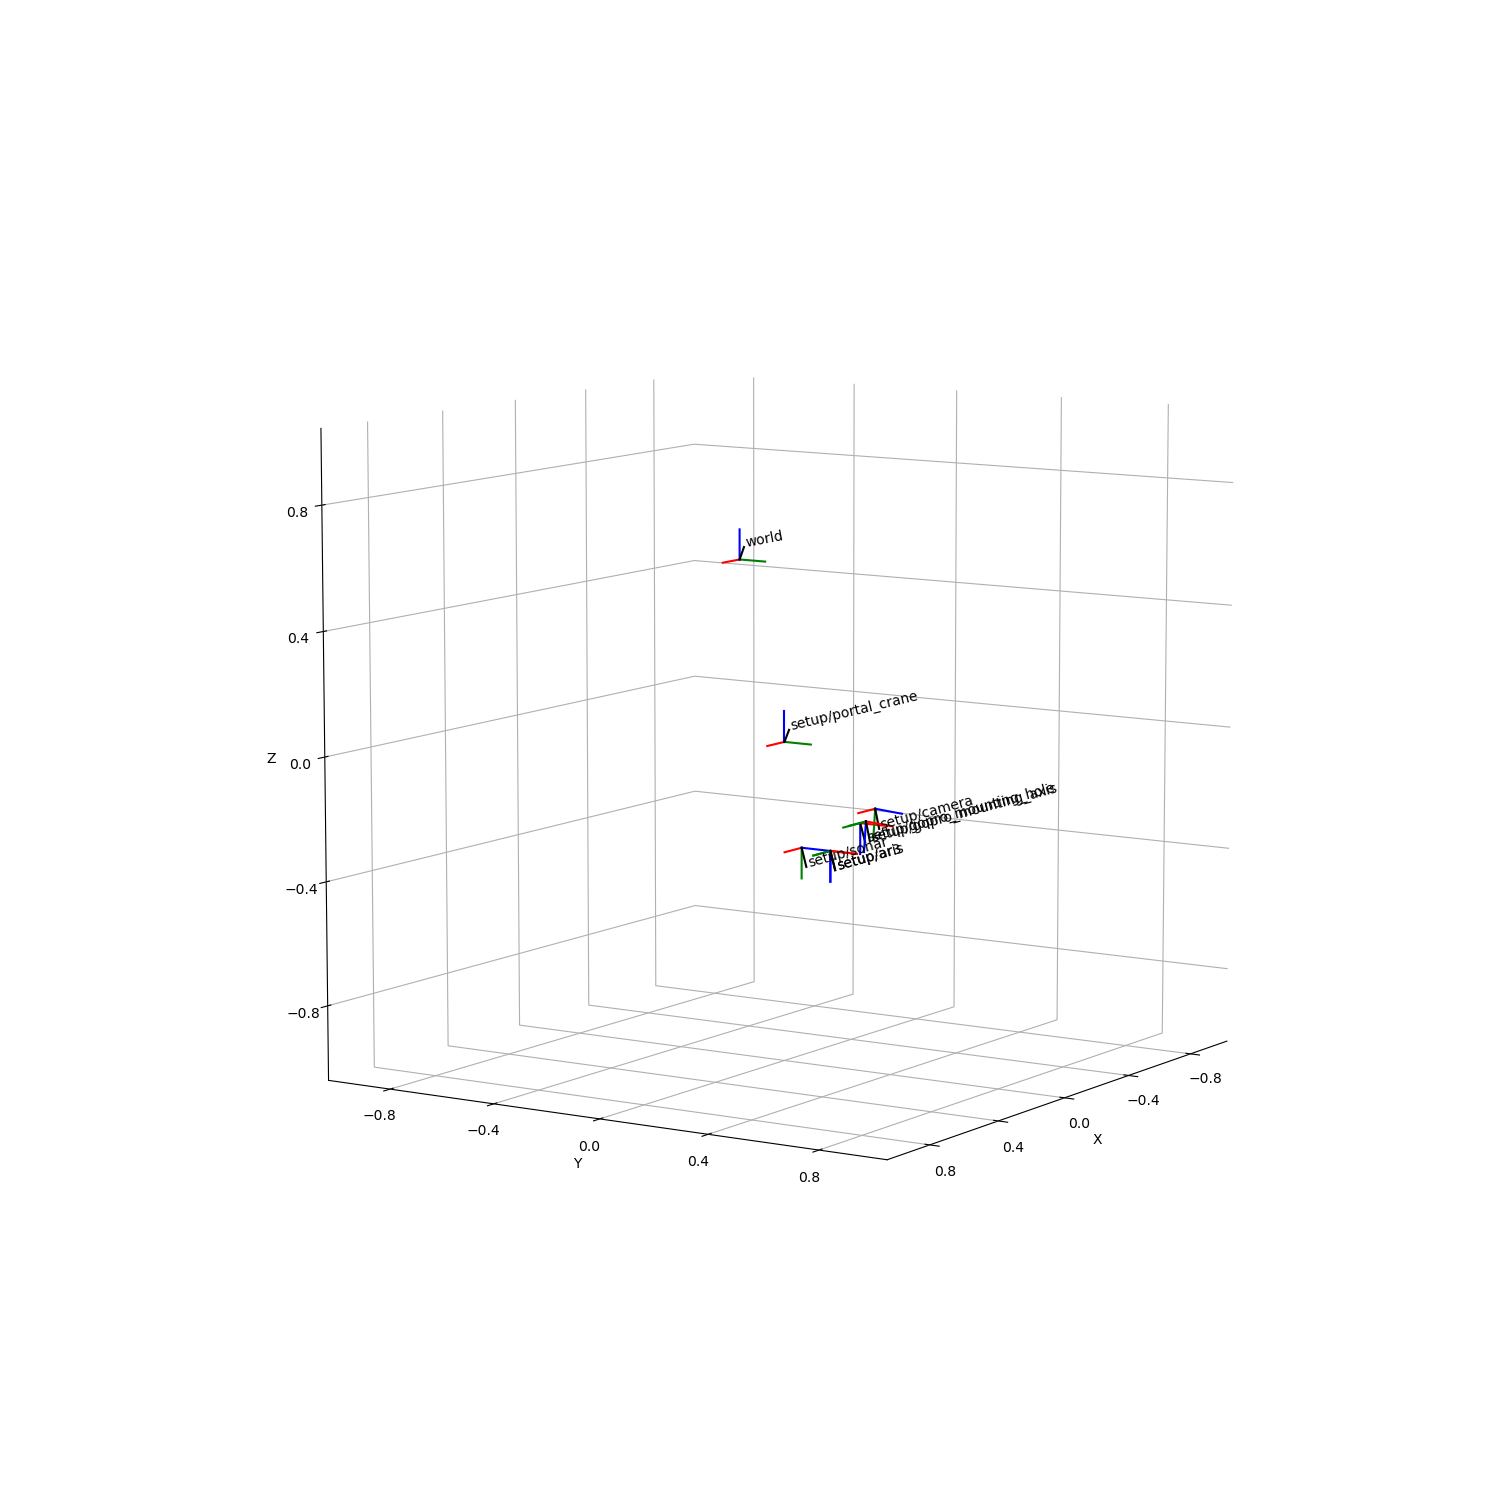

In [52]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
ax = tm.plot_frames_in("setup/portal_crane", s=0.1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.view_init(azim=33, elev=9.)
plt.show()

In [55]:
tm.get_transform("setup/camera", "world").round(4)

array([[ 1.    ,  0.    , -0.    ,  0.5035],
       [-0.    , -0.0698,  0.9976,  0.8438],
       [ 0.    , -0.9976, -0.0698, -0.6849],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])